Cat vs Dog Classifier

In [71]:
# !pip install bing-image-downloader
import os
import requests

import mlflow
import mlflow.keras
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNet

from datetime import datetime
import matplotlib.pyplot as plt

from bing_image_downloader import downloader
from pathlib import Path
import imghdr
import numpy as np


Download images

In [2]:
image_path = "./data/cat_dogs/"

In [3]:
# def download_images(query, limit, output_dir):
    
#     downloader.download(query,
#                         limit=limit,
#                         output_dir=output_dir,
#                         adult_filter_off=True,
#                         force_replace=False,
#                         timeout=60)

# download_images("cat", 100, image_path)
# download_images("dog", 100, image_path)

Check the downloaded images

In [5]:
for category in ["cat", "dog"]:
    data_dir = os.path.join(image_path, category)  # Set the directory path for each category
    image_extensions = [".png", ".jpg", ".jpeg", ".bmp", ".gif"]  # Add all common image formats

    img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]  # TensorFlow-supported formats

    for filepath in Path(data_dir).rglob("*"):  # Iterate through all files
        if filepath.suffix.lower() in image_extensions:
            img_type = imghdr.what(filepath)  # Check if it's a valid image

            if img_type is None:
                print(f"Deleting {filepath}: Not a valid image")
                os.remove(filepath)  # Delete invalid image

            elif img_type not in img_type_accepted_by_tf:
                print(f"Deleting {filepath}: {img_type} is not accepted by TensorFlow")
                os.remove(filepath)  # Delete unsupported image type

Model Training

Define parameters

In [27]:
# Define hyperparameters and input data
learning_rate = 0.01
num_epochs = 50
batch_size = 32
input_shape = (224, 224, 3)

In [8]:
# Define names for tensorboard logging and mlflow
experiment_name = "cat-dog-classifier-mobilenet"
run_name = datetime.now().strftime("%Y%m%d_%H%M%S")

Read Data

In [11]:
# Load the dataset
train_dataset = keras.preprocessing.image_dataset_from_directory(
    image_path,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=input_shape[:2],
    batch_size=batch_size,
)

Found 197 files belonging to 2 classes.
Using 158 files for training.


In [12]:
val_dataset = keras.preprocessing.image_dataset_from_directory(
    image_path,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=input_shape[:2],
    batch_size=batch_size,
)

Found 197 files belonging to 2 classes.
Using 39 files for validation.


Look at some sample images from the datasets

2025-02-19 09:37:45.406730: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


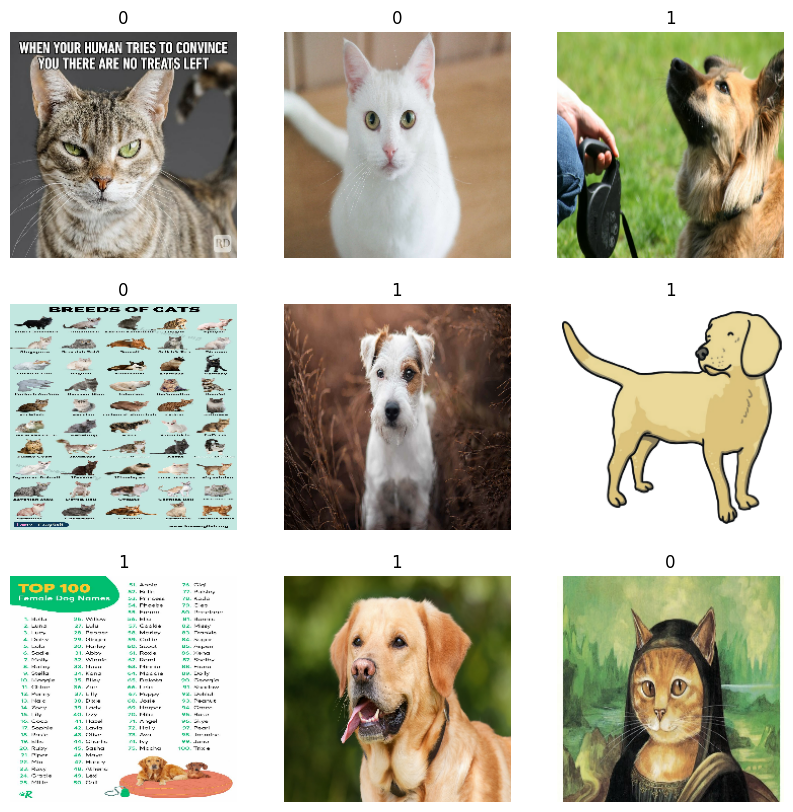

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

2025-02-19 09:38:08.086472: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


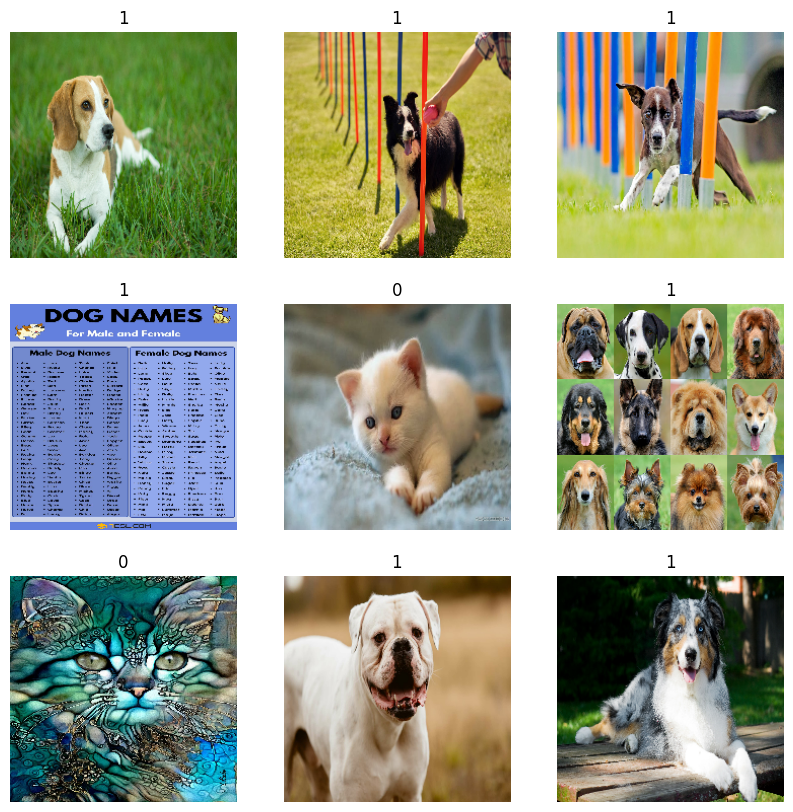

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in val_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Data Augmentation

In [15]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
    ]
)

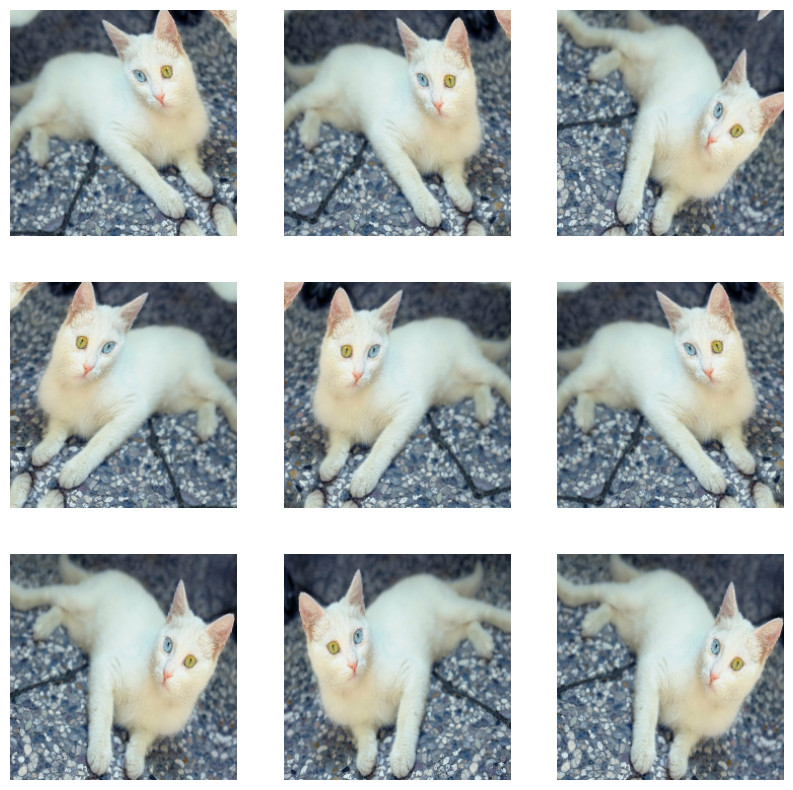

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [17]:
augmented_train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y))

Define Model and Train

In [18]:
# Define the base model and add a classifier on top
base_model = MobileNet(input_shape=input_shape, include_top=False, weights="imagenet")
base_model.trainable = False
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])

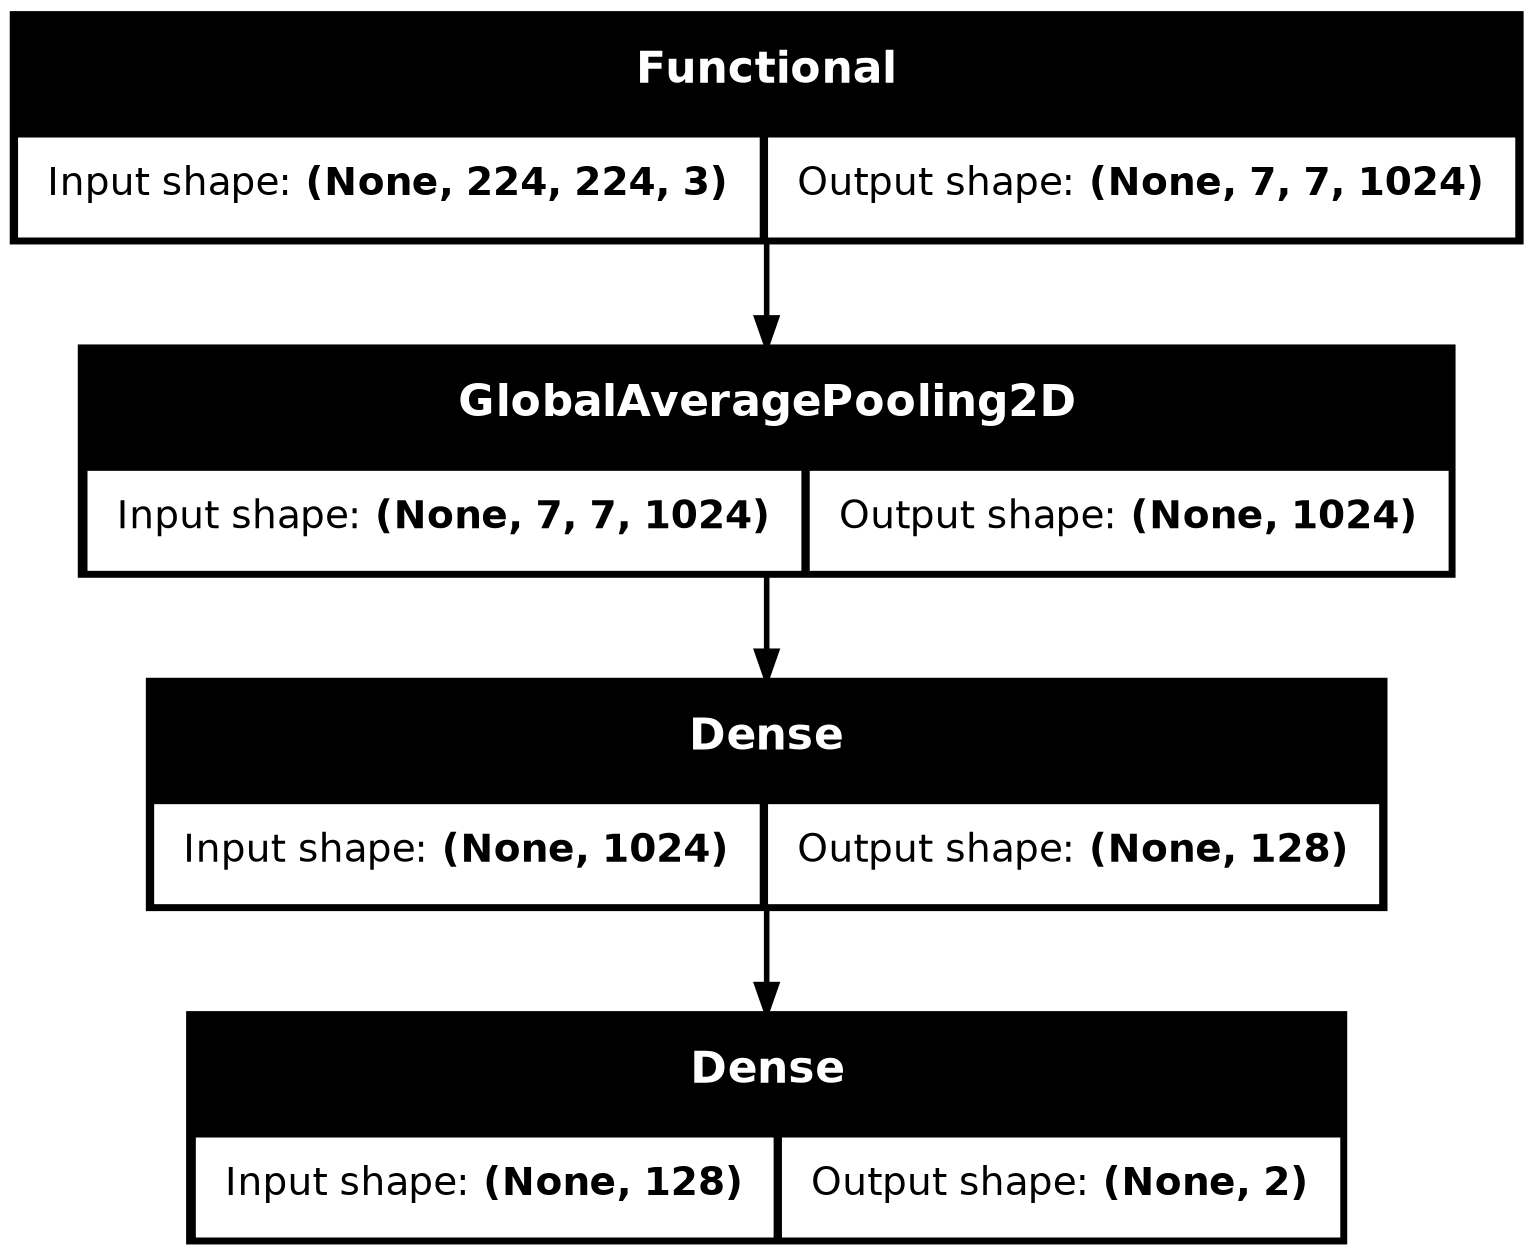

In [19]:
keras.utils.plot_model(model, show_shapes=True)

In [20]:
 # Compile the model with a loss function and optimizer
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=["accuracy"],
)

In [23]:
logdir = os.path.join("logs", experiment_name, run_name)
tb_callback = keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True, histogram_freq=1)

In [28]:
# Train the model and log metrics and the model itself to MLflow
history = model.fit(
    augmented_train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    verbose=2,
    callbacks=[tb_callback]
)

Epoch 1/50


2025-02-19 10:36:27.221883: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 536ms/step - accuracy: 0.9494 - loss: 0.1594 - val_accuracy: 0.8974 - val_loss: 0.2156
Epoch 2/50


2025-02-19 10:36:29.904245: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 549ms/step - accuracy: 0.9494 - loss: 0.1064 - val_accuracy: 0.8974 - val_loss: 0.2307
Epoch 3/50


2025-02-19 10:36:32.823415: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 537ms/step - accuracy: 0.9684 - loss: 0.0984 - val_accuracy: 0.9487 - val_loss: 0.2296
Epoch 4/50


2025-02-19 10:36:35.346676: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 538ms/step - accuracy: 0.9684 - loss: 0.0774 - val_accuracy: 0.8974 - val_loss: 0.1551
Epoch 5/50


2025-02-19 10:36:38.311369: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 542ms/step - accuracy: 0.9937 - loss: 0.0239 - val_accuracy: 0.9487 - val_loss: 0.1689
Epoch 6/50


2025-02-19 10:36:41.055429: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 710ms/step - accuracy: 0.9810 - loss: 0.0445 - val_accuracy: 0.9231 - val_loss: 0.2602
Epoch 7/50


2025-02-19 10:36:44.527636: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 702ms/step - accuracy: 0.9367 - loss: 0.1594 - val_accuracy: 0.8974 - val_loss: 0.3138
Epoch 8/50


2025-02-19 10:36:48.150128: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 683ms/step - accuracy: 0.9684 - loss: 0.0715 - val_accuracy: 0.8462 - val_loss: 0.3420
Epoch 9/50


2025-02-19 10:36:51.719177: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 678ms/step - accuracy: 0.9620 - loss: 0.0820 - val_accuracy: 0.8718 - val_loss: 0.2744
Epoch 10/50


2025-02-19 10:36:54.945862: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 688ms/step - accuracy: 0.9873 - loss: 0.0460 - val_accuracy: 0.9487 - val_loss: 0.1333
Epoch 11/50


2025-02-19 10:36:58.284751: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 713ms/step - accuracy: 0.9937 - loss: 0.0342 - val_accuracy: 0.9487 - val_loss: 0.1408
Epoch 12/50


2025-02-19 10:37:01.707189: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 715ms/step - accuracy: 0.9937 - loss: 0.0241 - val_accuracy: 0.9487 - val_loss: 0.1401
Epoch 13/50


2025-02-19 10:37:05.707437: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 716ms/step - accuracy: 0.9747 - loss: 0.0678 - val_accuracy: 0.9487 - val_loss: 0.1366
Epoch 14/50


2025-02-19 10:37:08.927611: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 689ms/step - accuracy: 0.9873 - loss: 0.0546 - val_accuracy: 0.9231 - val_loss: 0.1817
Epoch 15/50


2025-02-19 10:37:12.347776: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 678ms/step - accuracy: 0.9810 - loss: 0.0655 - val_accuracy: 0.9231 - val_loss: 0.1558
Epoch 16/50


2025-02-19 10:37:17.338736: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 5s - 964ms/step - accuracy: 0.9937 - loss: 0.0166 - val_accuracy: 0.8718 - val_loss: 0.2066
Epoch 17/50


2025-02-19 10:37:20.993289: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 692ms/step - accuracy: 0.9747 - loss: 0.0411 - val_accuracy: 0.9487 - val_loss: 0.1944
Epoch 18/50


2025-02-19 10:37:23.925690: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 722ms/step - accuracy: 0.9810 - loss: 0.0484 - val_accuracy: 0.8974 - val_loss: 0.2864
Epoch 19/50


2025-02-19 10:37:27.623040: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 764ms/step - accuracy: 0.9937 - loss: 0.0212 - val_accuracy: 0.8974 - val_loss: 0.2779
Epoch 20/50


2025-02-19 10:37:31.624623: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 701ms/step - accuracy: 0.9937 - loss: 0.0236 - val_accuracy: 0.9231 - val_loss: 0.3248
Epoch 21/50


2025-02-19 10:37:34.859980: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 697ms/step - accuracy: 0.9684 - loss: 0.0514 - val_accuracy: 0.9231 - val_loss: 0.2110
Epoch 22/50


2025-02-19 10:37:38.337833: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 718ms/step - accuracy: 0.9494 - loss: 0.1071 - val_accuracy: 0.8718 - val_loss: 0.2748
Epoch 23/50


2025-02-19 10:37:41.978121: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 692ms/step - accuracy: 0.9810 - loss: 0.0361 - val_accuracy: 0.9744 - val_loss: 0.1288
Epoch 24/50


2025-02-19 10:37:45.702685: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 700ms/step - accuracy: 1.0000 - loss: 0.0166 - val_accuracy: 0.9487 - val_loss: 0.1413
Epoch 25/50


2025-02-19 10:37:49.446514: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 695ms/step - accuracy: 0.9937 - loss: 0.0130 - val_accuracy: 0.9487 - val_loss: 0.1290
Epoch 26/50


2025-02-19 10:37:52.518128: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 693ms/step - accuracy: 0.9810 - loss: 0.0326 - val_accuracy: 0.9487 - val_loss: 0.1752
Epoch 27/50


2025-02-19 10:37:56.324596: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 691ms/step - accuracy: 0.9747 - loss: 0.0526 - val_accuracy: 0.9487 - val_loss: 0.1708
Epoch 28/50


2025-02-19 10:37:59.652974: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 701ms/step - accuracy: 0.9873 - loss: 0.0244 - val_accuracy: 0.9487 - val_loss: 0.1352
Epoch 29/50


2025-02-19 10:38:02.812882: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 692ms/step - accuracy: 1.0000 - loss: 0.0160 - val_accuracy: 0.9487 - val_loss: 0.1450
Epoch 30/50


2025-02-19 10:38:06.636774: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 696ms/step - accuracy: 0.9937 - loss: 0.0285 - val_accuracy: 0.8974 - val_loss: 0.2392
Epoch 31/50


2025-02-19 10:38:10.263741: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 694ms/step - accuracy: 0.9873 - loss: 0.0405 - val_accuracy: 0.9231 - val_loss: 0.1508
Epoch 32/50


2025-02-19 10:38:13.302891: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 693ms/step - accuracy: 0.9937 - loss: 0.0232 - val_accuracy: 0.9231 - val_loss: 0.2290
Epoch 33/50


2025-02-19 10:38:16.929272: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 699ms/step - accuracy: 0.9873 - loss: 0.0286 - val_accuracy: 0.8718 - val_loss: 0.3867
Epoch 34/50


2025-02-19 10:38:20.190117: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 703ms/step - accuracy: 0.9430 - loss: 0.1594 - val_accuracy: 0.9487 - val_loss: 0.2158
Epoch 35/50


2025-02-19 10:38:25.461437: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 5s - 960ms/step - accuracy: 0.9684 - loss: 0.0800 - val_accuracy: 0.8974 - val_loss: 0.2199
Epoch 36/50


2025-02-19 10:38:28.607340: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 717ms/step - accuracy: 0.9873 - loss: 0.0272 - val_accuracy: 0.8462 - val_loss: 0.4438
Epoch 37/50


2025-02-19 10:38:32.386175: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 700ms/step - accuracy: 0.9873 - loss: 0.0357 - val_accuracy: 0.9231 - val_loss: 0.2357
Epoch 38/50


2025-02-19 10:38:35.803269: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 708ms/step - accuracy: 0.9684 - loss: 0.0898 - val_accuracy: 0.9744 - val_loss: 0.2050
Epoch 39/50


2025-02-19 10:38:39.577256: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 727ms/step - accuracy: 0.9873 - loss: 0.0365 - val_accuracy: 0.8974 - val_loss: 0.1933
Epoch 40/50


2025-02-19 10:38:43.222556: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 710ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 0.9231 - val_loss: 0.2310
Epoch 41/50


2025-02-19 10:38:46.577383: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 708ms/step - accuracy: 0.9810 - loss: 0.0292 - val_accuracy: 0.8718 - val_loss: 0.2299
Epoch 42/50


2025-02-19 10:38:50.191417: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 711ms/step - accuracy: 0.9873 - loss: 0.0330 - val_accuracy: 0.9487 - val_loss: 0.1352
Epoch 43/50


2025-02-19 10:38:53.500546: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 703ms/step - accuracy: 0.9873 - loss: 0.0413 - val_accuracy: 0.9744 - val_loss: 0.1574
Epoch 44/50


2025-02-19 10:38:57.188918: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 704ms/step - accuracy: 0.9937 - loss: 0.0155 - val_accuracy: 0.9487 - val_loss: 0.1262
Epoch 45/50


2025-02-19 10:39:00.797480: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 719ms/step - accuracy: 0.9873 - loss: 0.0356 - val_accuracy: 0.8974 - val_loss: 0.2279
Epoch 46/50


2025-02-19 10:39:04.117534: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 705ms/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.8718 - val_loss: 0.2913
Epoch 47/50


2025-02-19 10:39:07.897806: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 723ms/step - accuracy: 0.9937 - loss: 0.0228 - val_accuracy: 0.9231 - val_loss: 0.1610
Epoch 48/50


2025-02-19 10:39:11.221421: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 726ms/step - accuracy: 0.9937 - loss: 0.0156 - val_accuracy: 0.8718 - val_loss: 0.2548
Epoch 49/50


2025-02-19 10:39:15.439711: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 777ms/step - accuracy: 0.9684 - loss: 0.0620 - val_accuracy: 0.8718 - val_loss: 0.3117
Epoch 50/50


2025-02-19 10:39:18.751166: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 782ms/step - accuracy: 0.9747 - loss: 0.0526 - val_accuracy: 0.8718 - val_loss: 0.4513


Logging and Visualization

In [29]:
# Set the experiment name and create an MLflow run
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name = run_name) as mlflow_run:
    
    mlflow.set_experiment_tag("base_model", "MobileNet")
    mlflow.set_tag("optimizer", "keras.optimizers.Adam")
    mlflow.set_tag("loss", "sparse_categorical_crossentropy")

    mlflow.keras.log_model(model, "model")

    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("input_shape", input_shape)

    mlflow.log_metric("train_loss", history.history["loss"][-1])
    mlflow.log_metric("train_acc", history.history["accuracy"][-1])
    mlflow.log_metric("val_loss", history.history["val_loss"][-1])
    mlflow.log_metric("val_acc", history.history["val_accuracy"][-1])

    mlflow.log_artifact("model.png", "model_plot")

    mlflow_run_id = mlflow_run.info.run_id
    print("MLFlow Run ID: ", mlflow_run_id)

2025/02/19 10:55:46 INFO mlflow.tracking.fluent: Experiment with name 'cat-dog-classifier-mobilenet' does not exist. Creating a new experiment.
2025/02/19 10:55:46 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/02/19 10:55:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLFlow Run ID:  5679393ab9f04ad7b30687a456825009


MLFlow Run ID:  5679393ab9f04ad7b30687a456825009 for 19-02-2025

Using Tensorboard within Jupyter

In [30]:
%load_ext tensorboard
%tensorboard --logdir logs/cat-dog-classifier-mobilenet

Reusing TensorBoard on port 6006 (pid 29392), started 6:25:12 ago. (Use '!kill 29392' to kill it.)

Predictions

In [98]:
img = keras.preprocessing.image.load_img(
    os.path.join(image_path, "dog/Image_5.jpg"), target_size=input_shape
    # os.path.join(image_path, "cat/Image_2.jpg"), target_size=input_shape
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Raw model predictions: [0.755164   0.24483602]
This image is 75.52% dog and 24.48% cat.


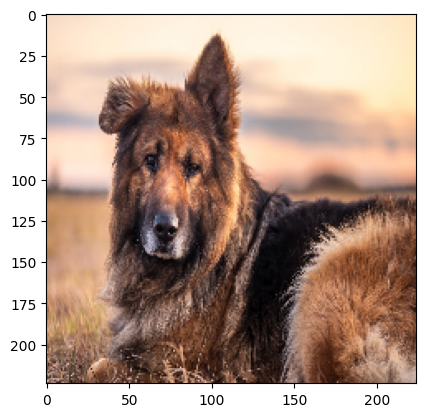

In [102]:
predictions = model.predict(img_array)
print("Raw model predictions:", predictions[0])

print("This image is {:.2f}% dog and {:.2f}% cat.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))

Using MLFlow to predict

In [51]:
# Logged model in MLFlow
logged_model_path = f"runs:/{mlflow_run_id}/model"

# Load model as a Keras model
loaded_model = mlflow.keras.load_model(logged_model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
This image is 97.14% dog and 2.86% cat.


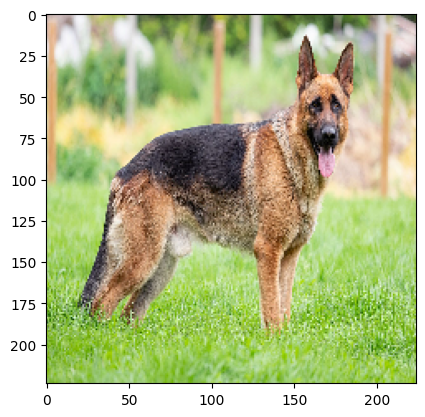

In [65]:
predictions = loaded_model.predict(img_array)
print("This image is {:.2f}% dog and {:.2f}% cat.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))

Model Registration

In [45]:
model_name = "cat_dog_classifier"
model_version = 1

In [46]:
print("MLFlow Run ID: ", mlflow_run_id)

MLFlow Run ID:  5679393ab9f04ad7b30687a456825009


In [47]:
with mlflow.start_run(run_id=mlflow_run_id) as run:
    result = mlflow.register_model(
        logged_model_path,
        model_name
    )

Successfully registered model 'cat_dog_classifier'.
Created version '1' of model 'cat_dog_classifier'.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
This image is 97.14% dog and 2.86% cat.


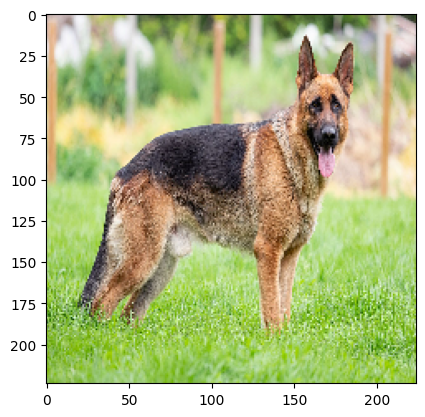

In [66]:
# Load model as a Keras model
loaded_model = mlflow.keras.load_model(
    model_uri=f"models:/{model_name}/{model_version}"
)

predictions = loaded_model.predict(img_array)
print("This image is {:.2f}% dog and {:.2f}% cat.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))

Transition model to production

In [54]:
client = mlflow.tracking.MlflowClient()
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage="Production"
)

/tmp/ipykernel_1001208/163353590.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1739966178748, current_stage='Production', description=None, last_updated_timestamp=1739968043849, name='cat_dog_classifier', run_id='5679393ab9f04ad7b30687a456825009', run_link=None, source='file:///home/megha/my_mlflow_project/Project/mlruns/929989691142411108/5679393ab9f04ad7b30687a456825009/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
This image is 97.14% dog and 2.86% cat.


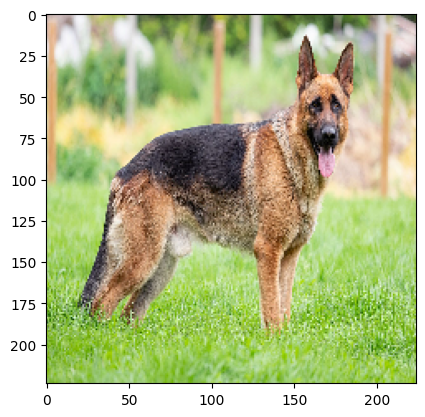

In [67]:
# Load model as a Keras model
loaded_model = mlflow.keras.load_model(
    model_uri=f"models:/{model_name}/production"
)

predictions = loaded_model.predict(img_array)
print("This image is {:.2f}% dog and {:.2f}% cat.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))

Create endpoint for model serving

Set environment variable for MLFlow URI

export MLFLOW_TRACKING_URI=http://localhost:5000

Start MLFlow Server for the model


mlflow models serve --model-uri models:/cat_dog_classifier/production -p 7777 --no-conda

In [56]:
endpoint = "http://localhost:7777/invocations"

This image is 97.14% dog and 2.86% cat.


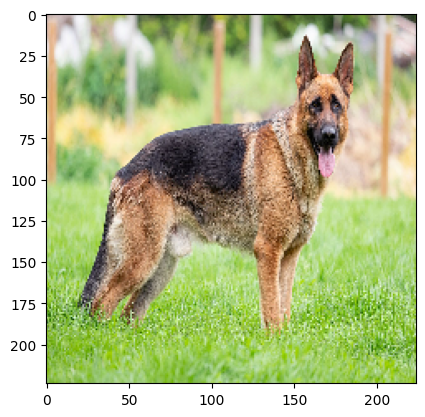

In [69]:
image_request = {
        "instances":img_array.numpy().tolist()
}

response = requests.post(endpoint, json=image_request)

predictions = eval(response.text)["predictions"]
print("This image is {:.2f}% dog and {:.2f}% cat.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))